In [0]:
# mount the google drive locally
from google.colab import drive
drive.mount('/content/gdrive')
PATH_DRIVE = "/content/gdrive/My Drive/Cross-Lingual-Embedding/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from collections import Counter
import io

import collections
import string
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from gensim.utils import lemmatize

import keras
from keras.datasets import imdb
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, LSTM
from keras.layers.embeddings import Embedding

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
PATH_IMDB_TRAIN = PATH_DRIVE + "Imdb_train.csv"
PATH_IMDB_TEST = PATH_DRIVE + "Imdb_test.csv"

PATH_CORPUS_CINE = PATH_DRIVE + "CorpusCine.csv"

PATH_MUSE_EN = PATH_DRIVE + "wiki.multi.en.vec"
PATH_MUSE_ES = PATH_DRIVE + "wiki.multi.es.vec"

PATH_DATA = PATH_DRIVE + "data/"

In [0]:
import pickle
def save_obj(obj, name ):
    with open(PATH_DRIVE+ name + '.pkl', 'wb') as f:
      pickle.dump(obj, f)#, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(PATH_DRIVE+ name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
cols = ["review","label"]
df = pd.read_csv(PATH_IMDB_TRAIN,header=None, names=cols)
df_test = pd.read_csv(PATH_IMDB_TEST,header=None, names=cols)
df = df.append(df_test)

In [0]:
df_es = pd.read_csv(PATH_CORPUS_CINE,header=None, names=cols)

In [0]:
df_es_save = pd.read_csv(PATH_CORPUS_CINE,header=None, names=cols)

In [0]:
print(df["label"].count())
print(df_es["label"].count())

50000
2275


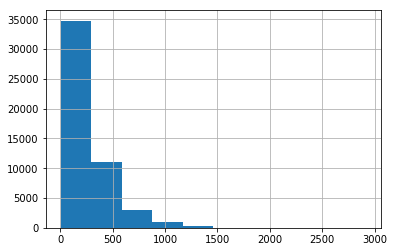

count    50000.00000
mean       279.13746
std        207.65861
min          8.00000
25%        151.00000
50%        209.00000
75%        339.00000
max       2909.00000
dtype: float64

In [0]:
reviews_len = [len(word_tokenize(x)) for x in df.review]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

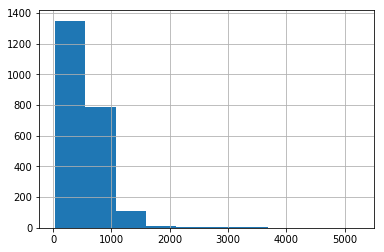

count    2275.000000
mean      572.864176
std       336.653609
min        26.000000
25%       367.000000
50%       492.000000
75%       686.500000
max      5247.000000
dtype: float64

In [0]:
reviews_len = [len(word_tokenize(x)) for x in df_es.review]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

# Spanish Preprocessing

In [0]:
df_es.review[0]

'Malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que\n        podr�an ser m�s corrosivos.\n    Al entrar al cine s�lo cabe una pregunta: �ser� tan mala como parece? Y al salir s�lo una respuesta: pudo ser\n        peor. �Ojo! Esto no quiere decir, ni mucho menos, que sea buena. Ni siquiera es mediocre. Pero se queda en\n        malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que podr�an\n        ser m�s corrosivos.Del argumento no hace falta ni hablar. Cuatro treinta�eros buscan su lugar en el mundo, y\n        todo gira, l�gicamente, en torno a las mujeres. Que si yo quiero casarme, que si a m� me han dejado, que si yo\n        no me como un rosco, que si yo soy un lig�n pero no encuentro el amor. en fin, cuatro situaciones m�s vistas que\n        el tebeo, que se mezclan sin gracia ni arte y que s�lo de vez en cuando son capaces de ofrecer alguna situaci�n\n        c�mica merecedora de

In [0]:
del_jump = lambda x: x.replace('\n','')
df_es['review'] = df_es['review'].apply(del_jump)
df_es.review[0]

'Malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que        podr�an ser m�s corrosivos.    Al entrar al cine s�lo cabe una pregunta: �ser� tan mala como parece? Y al salir s�lo una respuesta: pudo ser        peor. �Ojo! Esto no quiere decir, ni mucho menos, que sea buena. Ni siquiera es mediocre. Pero se queda en        malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que podr�an        ser m�s corrosivos.Del argumento no hace falta ni hablar. Cuatro treinta�eros buscan su lugar en el mundo, y        todo gira, l�gicamente, en torno a las mujeres. Que si yo quiero casarme, que si a m� me han dejado, que si yo        no me como un rosco, que si yo soy un lig�n pero no encuentro el amor. en fin, cuatro situaciones m�s vistas que        el tebeo, que se mezclan sin gracia ni arte y que s�lo de vez en cuando son capaces de ofrecer alguna situaci�n        c�mica merecedora de una sonrisa.Caf� 

In [0]:
unknown_char = df_es.review[0][39]
unknown_char

'�'

In [0]:
count = 0
for i in  df_es.review[2]:
  if i==unknown_char:
    count+=1
count

105

In [0]:
l_spanish_char = []
for review in df_es["review"]:
  count = 0
  for i in  review:
    if i==unknown_char:
      count+=1
  l_spanish_char.append(count)

In [0]:
table = collections.defaultdict(lambda: None)
table.update({
    ord('á'):'Ã¡',
    ord('é'):'Ã©',
    ord('í'):'Ãa',
    ord('ó'):'Ã³',
    ord('ú'):'Ãº',
    ord('ü'):'Ã¼Ãs',
    ord('ñ'):'e',
    ord('ô'):'Ã±',
    ord('ế'):'áº¿',
    ord(' '):' '
    })
table.update(dict(zip(map(ord,string.ascii_uppercase), string.ascii_lowercase)))
table.update(dict(zip(map(ord,string.ascii_lowercase), string.ascii_lowercase)))
table.update(dict(zip(map(ord,string.digits), string.digits)))

convert_char = lambda x: x.translate(table,)

In [0]:
print('are están also también you tú had tenía score puntuación years años football fútbol linguistic lingüístico film película'.translate(table,))

are estÃ¡n also tambiÃ©n you tÃº had tenÃaa score puntuaciÃ³n years aeos football fÃºtbol linguistic lingÃ¼ÃsÃastico film pelÃacula


In [0]:
df_es.review[0]

'Malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que        podr�an ser m�s corrosivos.    Al entrar al cine s�lo cabe una pregunta: �ser� tan mala como parece? Y al salir s�lo una respuesta: pudo ser        peor. �Ojo! Esto no quiere decir, ni mucho menos, que sea buena. Ni siquiera es mediocre. Pero se queda en        malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que podr�an        ser m�s corrosivos.Del argumento no hace falta ni hablar. Cuatro treinta�eros buscan su lugar en el mundo, y        todo gira, l�gicamente, en torno a las mujeres. Que si yo quiero casarme, que si a m� me han dejado, que si yo        no me como un rosco, que si yo soy un lig�n pero no encuentro el amor. en fin, cuatro situaciones m�s vistas que        el tebeo, que se mezclan sin gracia ni arte y que s�lo de vez en cuando son capaces de ofrecer alguna situaci�n        c�mica merecedora de una sonrisa.Caf� 

In [0]:
df_es.review[0].translate(table,)

'malilla torpona facilona simple vaca y otra serie de adjetivos que nunca son de halago pero que        podran ser ms corrosivos    al entrar al cine slo cabe una pregunta ser tan mala como parece y al salir slo una respuesta pudo ser        peor ojo esto no quiere decir ni mucho menos que sea buena ni siquiera es mediocre pero se queda en        malilla torpona facilona simple vaca y otra serie de adjetivos que nunca son de halago pero que podran        ser ms corrosivosdel argumento no hace falta ni hablar cuatro treintaeros buscan su lugar en el mundo y        todo gira lgicamente en torno a las mujeres que si yo quiero casarme que si a m me han dejado que si yo        no me como un rosco que si yo soy un lign pero no encuentro el amor en fin cuatro situaciones ms vistas que        el tebeo que se mezclan sin gracia ni arte y que slo de vez en cuando son capaces de ofrecer alguna situacin        cmica merecedora de una sonrisacaf solo o con ellas ser otra de esas pelculas que en dos

In [0]:
df_es['review'] = df_es['review'].apply(convert_char)
df_es.review[0]

'malilla torpona facilona simple vaca y otra serie de adjetivos que nunca son de halago pero que        podran ser ms corrosivos    al entrar al cine slo cabe una pregunta ser tan mala como parece y al salir slo una respuesta pudo ser        peor ojo esto no quiere decir ni mucho menos que sea buena ni siquiera es mediocre pero se queda en        malilla torpona facilona simple vaca y otra serie de adjetivos que nunca son de halago pero que podran        ser ms corrosivosdel argumento no hace falta ni hablar cuatro treintaeros buscan su lugar en el mundo y        todo gira lgicamente en torno a las mujeres que si yo quiero casarme que si a m me han dejado que si yo        no me como un rosco que si yo soy un lign pero no encuentro el amor en fin cuatro situaciones ms vistas que        el tebeo que se mezclan sin gracia ni arte y que slo de vez en cuando son capaces de ofrecer alguna situacin        cmica merecedora de una sonrisacaf solo o con ellas ser otra de esas pelculas que en dos

# Preprocessing

## Tokenize — Encode the words

In [0]:
def clean(sentence):
  
  # lowercase
  sentence = sentence.lower()
  
  # punctuation
  sentence = ''.join([c for c in sentence if c not in punctuation])

  # tokenize
  tokens = word_tokenize(sentence)
  
  return tokens

In [0]:
def clean_es(sentence):
  
  # lowercase
  sentence = sentence.lower()
  
  # punctuation
  sentence = ''.join([c.translate(table,) for c in sentence if c not in punctuation])
  
  # tokenize
  tokens = word_tokenize(sentence)
  
  return tokens

In [0]:
def preprocessing(df):
  
  cleaned_rev = []
  count = Counter()
  for review in df["review"]:
#     print(review)
    rev = clean(review)
    cleaned_rev.append(rev)
    count.update(rev)
   
  vocab_to_int = {w:i for i, (w,c) in enumerate(count.most_common())}
  
  vocab_to_word = {i:w for (w,i) in vocab_to_int.items()}
    
  return cleaned_rev, vocab_to_int, vocab_to_word

In [0]:
def preprocessing_es(df):
  
  cleaned_rev = []
  count = Counter()
  for review in df["review"]:
#     print(review)
    rev = clean_es(review)
    cleaned_rev.append(rev)
    count.update(rev)
   
  vocab_to_int = {w:i for i, (w,c) in enumerate(count.most_common())}
  
  vocab_to_word = {i:w for (w,i) in vocab_to_int.items()}
    
  return cleaned_rev, vocab_to_int, vocab_to_word

In [0]:
cleaned_rev, vocab_to_int, vocab_to_word = preprocessing(df)

In [0]:
es_cleaned_rev, es_vocab_to_int, es_vocab_to_word = preprocessing(df_es)

In [0]:
list(es_vocab_to_int.items())[:3]

[('de', 0), ('que', 1), ('la', 2)]

# Embeddings

## load

In [0]:
def load_vec(emb_path, nmax):
    '''
    INPUT:
    emb_path: path of the txt file where the word embeddings are
    nmax: maxium number of word embeddings you want to load (I guess that
    the words are ordered from more frequent to least frequent)
    
    OUTPUT:
    embedings: array of dimensions words(nmax) x embedding dimensions (300)
    id2word: dictionary id (keys) word(values)
    word2id: dictionary word (keys) id(values)
    '''
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [0]:
nmax = 50000
src_embeddings, src_id2word, src_word2id = load_vec(PATH_MUSE_EN, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(PATH_MUSE_ES, nmax)

In [0]:
print("muse eng dim : ", src_embeddings.shape)
print("muse es dim : ", tgt_embeddings.shape)

muse eng dim :  (50000, 300)
muse es dim :  (50000, 300)


## Update Embeddings Indexing

In [0]:
list_src = list(src_word2id.keys())
list_imdb = list(vocab_to_int.keys())
list_common = []
c=0
for word in list_imdb:
  if word in list_src:
    list_common.append(word)
  else :
    c += 1
print("missing : {}%".format((c/len(list_imdb)*100)))

missing : 80.29778507877357%


In [0]:
print(len(list_common))
print(list(src_word2id.keys())[:5])
print(list_common[:5])

35741
[',', '.', 'the', '</s>', 'of']
['the', 'and', 'a', 'of', 'to']


In [0]:
voc_to_id = {w:i for i,w in enumerate(list_common)}
voc_to_word = {i:w for i,w in enumerate(list_common)}

In [0]:
es_voc_to_id = load_obj("es_voc_to_id" )
voc_to_id = load_obj("en_voc_to_id" )
print(len(es_voc_to_id))
len(voc_to_id)

20385


35741

In [0]:
print((35741/50000)*100)
print((20385/50000)*100)

71.482
40.77


In [0]:
voc_to_word = {i:w for (w,i) in voc_to_id.items()}
es_voc_to_word = {i:w for (w,i) in es_voc_to_id.items()}

In [0]:
print(list(voc_to_id.items())[:10])

[('the', 0), ('and', 1), ('a', 2), ('of', 3), ('to', 4), ('is', 5), ('in', 6), ('it', 7), ('i', 8), ('this', 9)]


In [0]:
print(list(vocab_to_int.items())[:10])

[('the', 0), ('and', 1), ('a', 2), ('of', 3), ('to', 4), ('is', 5), ('in', 6), ('it', 7), ('i', 8), ('this', 9)]


In [0]:
voc_emb_id={}
wordsno=[]
for i, word in voc_to_word.items():
    try:
        src_word2id[word]          
        voc_emb_id[word] = i
    except KeyError:
        wordsno.append(word)
        pass
      
print(len(voc_emb_id))
      
nb_words = 300
ordered_emb = np.zeros((len(voc_to_id), nb_words))

for word, index in voc_emb_id.items():
    en_id = src_word2id[word]
    ordered_emb[index] = src_embeddings[en_id][:nb_words]
print(ordered_emb.shape)


35741
(35741, 300)


In [0]:
print((len(wordsno)/len(list(vocab_to_word.items())))*100)
len(list(vocab_to_word.items()))-len(wordsno)

0.0


181406

In [0]:
print(src_id2word[2])
for i, emb in enumerate(ordered_emb):
  if emb[0] == src_embeddings[2][0]:
      print(vocab_to_word[i])

the
the


In [0]:
ordered_emb.shape

(35741, 300)

## Update spanish embeddings

In [0]:
# print(len(list(es_vocab_to_int.items())))

In [0]:
# print(es_vocab_to_int.keys())
# print(es_vocab_to_int["historia"])
# print(tgt_word2id["historia"])
# emb_es_hist = tgt_embeddings[tgt_word2id["historia"]]

In [0]:
# list_w = ['historia', 'que', 'la', 'y']
# list_emb = [tgt_embeddings[tgt_word2id[i]] for i in list_w]

In [0]:
# def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
#     print("Nearest neighbors of \"%s\":" % word)
#     word2id = {v: k for k, v in src_id2word.items()}
#     word_emb = src_emb[word2id[word]]
#     scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
#     k_best = scores.argsort()[-K:][::-1]
#     for i, idx in enumerate(k_best):
#       print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))
# #       print(idx)

In [0]:
# def get_closest(word_emb, src_emb, tgt_emb):
#     scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
#     k_best = scores.argsort()[-1:][::-1]
#     return k_best[0]

In [0]:
# nb_features = 300

# en_emb_50 = np.zeros((len(src_embeddings), nb_features))
# for i,emb in enumerate(src_embeddings):
#   en_emb_50[i] = emb[:nb_features]
  
# es_emb_50 = np.zeros((len(tgt_embeddings), nb_features))
# for i,emb in enumerate(tgt_embeddings):
#   es_emb_50[i] = emb[:nb_features]
  
# ord_emb_50 = np.zeros((len(ordered_emb), nb_features))
# for i,emb in enumerate(ordered_emb):
#   ord_emb_50[i] = emb[:nb_features]

In [0]:

# get_nn("historia", en_emb_50, src_id2word, es_emb_50, tgt_id2word, K=1)

In [0]:
# for w in list_w:
#   emb = tgt_embeddings[tgt_word2id[w]]
# #   print("{} :".format(w))#
#   #closest_word(voc_emb_id, ordered_emb, vocab_to_word, emb)))
#   get_nn(w, es_emb_50, tgt_id2word, ord_emb_50, voc_to_word, K=1)
# #   print(get_closest(emb, tgt_embeddings, ordered_emb))

In [0]:
# es_voc_to_id = {}
# miss=[]
# for i,word in enumerate(es_vocab_to_int.keys()):
#   if not i%300:
#     print("{}% : {}% missing".format( (i/len(es_vocab_to_int.keys()))*100, ((len(miss)+1)/(i+1)*100)))
#   try : 
#     emb = es_emb_50[tgt_word2id[word]]
#     es_voc_to_id[word] = get_closest(emb,es_emb_50, ord_emb_50)
#   except KeyError:
#     miss.append(word)
#     pass

In [0]:
# save_obj(es_voc_to_id, "es_voc_to_id_300" )
# save_obj(voc_to_id, "en_voc_to_id_300" )

In [0]:
# print(len(miss))

In [0]:
# es_vocab_to_id = load_obj("es_voc_to_id" )
# en_voc_to_id = load_obj("en_voc_to_id" )
# print(len(es_vocab_to_id))
# len(en_voc_to_id)

In [0]:
es_reviews_int = []
for review in es_cleaned_rev:
    r = [es_voc_to_id[w] for w in review if w in es_voc_to_id.keys()]
    es_reviews_int.append(r)
print (es_reviews_int[0:3])

[[570, 6156, 1, 151, 211, 3, 14269, 10, 108, 22, 3, 17, 10, 25, 1486, 0, 2191, 0, 18, 1302, 2, 6369, 25, 175, 320, 13, 180, 1, 0, 740, 2, 3312, 1925, 25, 241, 828, 10, 1045, 469, 127, 1045, 71, 336, 10, 25, 48, 1045, 53, 5, 1488, 17, 61, 2659, 6, 570, 6156, 1, 151, 211, 3, 14269, 10, 108, 22, 3, 17, 10, 25, 1486, 3639, 1045, 156, 537, 1045, 1038, 666, 4298, 23, 272, 6, 0, 187, 1, 262, 24468, 6, 181, 4, 125, 365, 10, 42, 1744, 21, 10, 42, 4, 3837, 68, 73, 535, 10, 42, 1744, 1045, 68, 13, 2, 10, 42, 1744, 68, 2, 17, 1045, 2383, 0, 109, 6, 4982, 666, 1109, 1486, 2708, 10, 0, 10, 61, 6914, 17, 8264, 1045, 523, 1, 10, 3, 274, 6, 49, 22, 464, 3, 1395, 96, 3, 2, 60, 38, 14, 76, 25, 151, 3, 125, 10, 6, 106, 8755, 261, 0, 9344, 10761, 0, 1957, 3, 2, 1890, 3, 149, 3, 1, 0, 0, 2807, 212, 16356, 17, 1245, 17, 1045, 175, 1245, 1045, 175, 16356, 61, 594, 0, 18, 14, 0, 413, 3, 10, 125, 666, 1887, 1, 125, 666, 3555, 10, 31, 125, 61, 7, 5, 320, 17, 13394, 17, 1045, 1091, 3, 42, 1045, 21, 157, 115, 10, 

In [0]:
es_labels = []
for label in df_es["label"]:
    es_labels.append(label)

# Indexing English dataset

In [0]:
vocab_to_int = voc_to_id
vocab_to_word = voc_to_word

In [0]:
reviews_int = []
for i,review in enumerate(cleaned_rev):
    r = [vocab_to_int[w] for w in review  if w in vocab_to_int.keys()]
    reviews_int.append(r)
print (reviews_int[0:3])

[[8, 193, 9, 16, 67, 397, 54, 1438, 8, 378, 84, 56, 21, 229, 42, 121, 5377, 302, 21, 19, 121, 1991, 264, 15, 121, 2891, 8, 56, 25, 13411, 28, 8153, 13, 2, 212, 17, 8, 148, 158, 7, 154, 29, 30, 8, 193, 7, 39, 632, 246, 668, 913, 1, 515, 92, 8, 1745, 109, 2081, 9490, 90, 17, 9, 5, 32, 1432, 1589, 934, 407, 6, 151, 11994, 117, 61, 274, 172, 1542, 10, 795, 1, 518, 5178, 22, 20, 3289, 6, 893, 7, 67, 2, 562, 537, 3, 1220, 1, 8, 6986, 90, 37, 9, 8, 368, 10, 83, 75, 4403, 9, 16, 1, 28, 5178, 82, 7, 5, 39, 2, 16, 17, 8, 124, 848, 31, 52, 938, 10, 9, 81, 4494, 25, 1476, 19, 281, 140, 20, 255, 4, 127, 10, 42, 21, 485, 9, 16, 21, 22, 2, 81, 394, 13, 295, 5, 5054, 4, 63, 197, 649, 1, 492, 3, 9, 16, 65, 716, 140, 39, 593, 10, 6, 143, 118, 83, 110, 37, 0, 100, 6, 9, 18, 65, 388, 5, 7798], [9, 16, 12, 372, 8, 193, 14, 30, 0, 45, 47, 518, 149, 7, 56, 25, 122, 88, 430, 121, 59, 3879, 2488, 12, 374, 58, 138, 1204, 4, 1718, 10263, 808, 10531, 5, 1485, 2, 927, 291, 0, 955, 26, 91, 6, 0, 16, 8, 95, 108, 25,

In [0]:
labels = []
for label in df["label"]:
    labels.append(label)

## Analyzing length

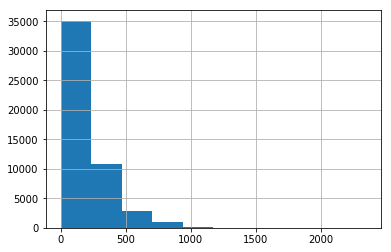

count    50000.000000
mean       218.277440
std        161.551621
min          2.000000
25%        120.000000
50%        164.000000
75%        264.000000
max       2342.000000
dtype: float64

In [0]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

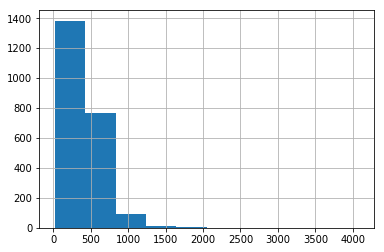

count    2275.000000
mean      437.807033
std       258.009712
min        21.000000
25%       284.000000
50%       376.000000
75%       522.500000
max      4082.000000
dtype: float64

In [0]:
es_reviews_len = [len(x) for x in es_reviews_int]
pd.Series(es_reviews_len).hist()
plt.show()
pd.Series(es_reviews_len).describe()

## Outlier

In [0]:
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
labels = [ labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

es_reviews_int = [ es_reviews_int[i] for i, l in enumerate(es_reviews_len) if l>0 ]
es_labels = [ es_labels[i] for i, l in enumerate(es_reviews_len) if l> 0 ]

## Padding

In [0]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    index_trunc = []
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
            index_trunc.append(i)
        
        features[i,:] = np.array(new)
    
    return features, index_trunc

In [0]:
len_feat = 300
features, ind_trunc = pad_features(reviews_int, len_feat)
es_features, es_ind_trunc = pad_features(es_reviews_int, len_feat)

In [0]:
len(es_ind_trunc)/len(es_reviews_int)

0.6958241758241758

In [0]:
feature_s = features.copy()
labels_s = labels.copy()

labels_a = np.array(labels)
indices = np.arange(features.shape[0])
np.random.shuffle(indices)

features = features[indices]
labels = labels_a[indices]

In [0]:
features

array([[   0,    0,    0, ...,   52,  328,  112],
       [   0,    0,    0, ...,   71,  122, 2141],
       [   0,    0,    0, ...,   11,   20, 1107],
       ...,
       [   0,    0,    0, ...,  664,   44,    3],
       [   0,    0,    0, ...,  575,    0, 2004],
       [   0,    0,    0, ...,   20,    2,   11]])

In [0]:
labels

array([1, 0, 0, ..., 0, 0, 0])

In [0]:
es_feature_s = es_features.copy()
es_labels_s = es_labels.copy()

es_labels_a = np.array(es_labels)
es_indices = np.arange(es_features.shape[0])
np.random.shuffle(es_indices)

es_features = es_features[es_indices]
es_labels = es_labels_a[es_indices]

In [0]:
split_frac = 0.8

train_x = features[0:int(split_frac*len(features))]
train_y = labels[0:int(split_frac*len(features))]

remaining_x = features[int(split_frac*len(features)):]
remaining_y = labels[int(split_frac*len(features)):]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [0]:
y = np.bincount(train_y)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[    0, 20001],
       [    1, 19999]])

In [0]:
y = np.bincount(valid_y)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[   0, 2518],
       [   1, 2482]])

In [0]:
y = np.bincount(test_y)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[   0, 2481],
       [   1, 2519]])

# Model

In [0]:
# define model
model = Sequential()
e = Embedding(ordered_emb.shape[0], ordered_emb.shape[1], weights=[ordered_emb], input_length=len_feat, trainable=False)
model.add(e)
model.add(LSTM(50, dropout = 0.6))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          10722300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,792,551
Trainable params: 70,251
Non-trainable params: 10,722,300
_________________________________________________________________
None


In [0]:
def plot(history, nb_epochs):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    first_epoch = 0
    epochs = range(first_epoch + 1, nb_epochs + 1)

    plt.plot(epochs, loss_values[first_epoch:], 'b', label='Training loss')
    plt.plot(epochs, val_loss_values[first_epoch:], 'r', label='Validation loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show(block=False);

    plt.clf()
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    plt.plot(epochs, acc_values[first_epoch:], 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc_values[first_epoch:], 'r', label='Validation Accuracy')
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show(block=False);

In [0]:
def stats(model, x_train, y_train):
  y_predict = model.predict(x_train)
  l_pred = [round(x[0]) for x in list(y_predict)]
  tp = [i for i, val in enumerate(l_pred) if val == y_train[i] and val]
  tn = [i for i, val in enumerate(l_pred) if val == y_train[i] and not val]
  fp = [i for i, val in enumerate(l_pred) if val != y_train[i] and val]
  fn = [i for i, val in enumerate(l_pred) if val != y_train[i] and not val]
  TP, TN, FP, FN = len(tp), len(tn), len(fp), len(fn)
  accuracy = (TP + TN)/(TP + TN + FP + FN)
  F1_score = 2*TP / (2*TP + FP + FN + keras.backend.epsilon())
  return tp,tn,fn,fp,accuracy, F1_score

In [0]:
nb_epochs = 10
history = model.fit(train_x, train_y, batch_size = 32, epochs=nb_epochs, validation_data=(valid_x, valid_y), verbose=1)

In [0]:
# model.load_weights(PATH_DRIVE+"model_e10_with_muse.h5")

In [0]:
plot(history, nb_epochs)

In [0]:
loss, accuracy = model.evaluate(test_x, test_y, verbose=1)
print('Accuracy: %f' % (accuracy*100))

5000/5000 [==============================] - 30s 6ms/step
Accuracy: 87.060000


In [0]:
loss, accuracy = model.evaluate(es_features, es_labels, verbose=1)
print('Accuracy: %f' % (accuracy*100))

2275/2275 [==============================] - 14s 6ms/step
Accuracy: 72.967033


# Error_Analysis


In [0]:
tp,tn,fn,fp,accuracy, F1 = stats(model, test_x, test_y)
print(accuracy)
print(F1)

0.8706
0.8702626829582863


In [0]:
tp,tn,fn,fp,accuracy, F1 = stats(model, es_features, es_labels)
print(accuracy)
print(F1)

0.7296703296703296
0.7673098751128525


In [0]:
print(len(tp))
print(len(tn))
print(len(fp))
print(len(fn))

1014
646
484
131


In [0]:
print("average number of unknown char by review")
avg_tn = 0
for i in tn :
  avg_tn += l_spanish_char[i]
print(avg_tn/len(tn))
avg_tp = 0
for i in tp :
  avg_tp += l_spanish_char[i]
print(avg_tp/len(tp))
avg_fp = 0
for i in fp :
  avg_fp += l_spanish_char[i]
print(avg_fp/len(fp))
avg_fn = 0
for i in fn :
  avg_fn += l_spanish_char[i]
print(avg_fn/len(fn))

average number of unknown char by review
50.671826625387
49.989151873767256
51.235537190082646
47.954198473282446


In [0]:
print("average percent of truncated review")
avg_tn = 0
for i in tn :
  if i in es_ind_trunc:
    avg_tn += 1
avg_tp = 0
for i in tp :
  if i in es_ind_trunc:
    avg_tp += 1
print((avg_tn/len(es_ind_trunc)*100+avg_tp/len(es_ind_trunc)*100))
avg_fn = 0
for i in fn :
  if i in es_ind_trunc:
    avg_fn += 1
avg_fp = 0
for i in fp :
  if i in es_ind_trunc:
    avg_fp += 1
print((avg_fn/len(es_ind_trunc)*100+avg_fp/len(es_ind_trunc)*100))

average percent of truncated review
73.27858496525585
26.721415034744158


In [0]:
# get the list used for shuffling
l_ind = list(es_indices)
# check if the first review after shuffling can be map to the one before shuffling
# es_features is the shuffled list
# es_feature_s is the list before shuffling
es_features[0] == es_feature_s[l_ind[0]]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [0]:
# Apply this to find the top false positives
for ind in fp[:3]:
  print("review {} : {}".format(l_ind[ind], df_es_save.review[l_ind[ind]]))  
  print("number of words of review  {} : {}".format(l_ind[ind], len(word_tokenize(df_es_save.review[l_ind[ind]]))))

review 1954 : Una pel�cula que aunque no se le puede quitar la etiqueta de entretenida, para mi resulta la m�s floja de
        la saga, y que vislumbrando toda la saga como una grand�sima pel�cula, creo que nos encontramos ante la pel�cula
        que sirve de nexo de uni�n entre todo el desarrollo de las pel�culas anteriores.
    Ya tenemos aqu� al casi "eterno" aprendiz de mago, en una quinta entrega que en un principio propon�a grandes
        cambios y grandes retos. Estos cambios y retos se basan directamente en la adaptaci�n del libro m�s largo de
        todos los de la saga Potter, y viendo la duraci�n de las otras pel�culas esta se antojaba eterna a la hora de
        adaptarla, aunque visto lo visto parece que han optado por el tijeretazo directamente a la hora de saltarse
        cap�tulos y mas cap�tulos, hasta dejar solo una trama principal que poder seguir durante todo el metraje. En
        segundo lugar, los cambios se refieren a esa medio adolescencia que ya tiene nue

In [0]:
print("review {} : {}".format(l_ind[ind], df_es_save.review[l_ind[0]]))
print("number of words of review {} : {}".format(l_ind[ind], len(word_tokenize(df_es_save.review[l_ind[0]]))))

review 327 : Un espect�culo que apunta y da en el blanco, que no es habitual en la actual cartelera. En resumen, si
        quieren saber lo que es una aventura �pica, aqu� est� para ustedes:
    El universo Tolkien parece a primera vista un desaf�o inabarcable tanto por su extensi�n como por sus
        infinitas sub-tramas y sus varios y variados personajes. Despu�s de ver esta pel�cula y la direcci�n que realiza
        en ella Peter Jackson, pareciera bastante f�cil de hacerlo o por lo menos, la mejor manera de lograrlo. M�s
        incre�ble parece que sea el mismo Jackson que comenz� su carrera con Bad Taste (Mal gusto, 1988) una pel�cula
        gore-trash con el f�cil r�tulo de bizarra, pero de una simpat�a y una improvisaci�n en dosis exageradas,
        demostrando ahora un crecimiento y madurez (con films de transici�n como Criaturas Celestiales) poco visto en
        directores de su camada.As� de disfrutable vuelve a ser el recorrido por m�s de tres horas y pico de acci�n 

In [0]:
print("review {} : {}".format(l_ind[ind], word_tokenize(df_es_save.review[l_ind[0]]))[-300:])  
print("number of words of review {} : {}".format(l_ind[ind], len(word_tokenize(df_es_save.review[l_ind[0]]))))

e', 'no', 'es', 'habitual', 'en', 'la', 'actual', 'cartelera', '.', 'En', 'resumen', ',', 'si', 'quieren', 'saber', 'lo', 'que', 'es', 'una', 'aventura', '�pica', ',', 'aqu�', 'est�', 'para', 'ustedes', ':', 'El', 'se�or', 'de', 'los', 'anillos', ':', 'Las', 'dos', 'torres', '.', 'Disfr�tenla', '.']
number of words of review 327 : 601


In [0]:
# Apply this to find the true positives
for ind in tp[:2]:
  print("review {} : {}".format(l_ind[ind], df_es_save.review[l_ind[ind]]))  
  print("number of words of review {} : {}".format(l_ind[ind], len(word_tokenize(df_es_save.review[l_ind[ind]]))))

review 443 : Un espect�culo que apunta y da en el blanco, que no es habitual en la actual cartelera. En resumen, si
        quieren saber lo que es una aventura �pica, aqu� est� para ustedes:
    El universo Tolkien parece a primera vista un desaf�o inabarcable tanto por su extensi�n como por sus
        infinitas sub-tramas y sus varios y variados personajes. Despu�s de ver esta pel�cula y la direcci�n que realiza
        en ella Peter Jackson, pareciera bastante f�cil de hacerlo o por lo menos, la mejor manera de lograrlo. M�s
        incre�ble parece que sea el mismo Jackson que comenz� su carrera con Bad Taste (Mal gusto, 1988) una pel�cula
        gore-trash con el f�cil r�tulo de bizarra, pero de una simpat�a y una improvisaci�n en dosis exageradas,
        demostrando ahora un crecimiento y madurez (con films de transici�n como Criaturas Celestiales) poco visto en
        directores de su camada.As� de disfrutable vuelve a ser el recorrido por m�s de tres horas y pico de acci�n 

In [0]:
print("review {} : {}".format(l_ind[tp[0]], df_es_save.review[l_ind[tp[0]]]))
print("number of words of review {} : {}".format(l_ind[tp[0]], len(word_tokenize(df_es_save.review[tp[0]]))))

review 443 : Un espect�culo que apunta y da en el blanco, que no es habitual en la actual cartelera. En resumen, si
        quieren saber lo que es una aventura �pica, aqu� est� para ustedes:
    El universo Tolkien parece a primera vista un desaf�o inabarcable tanto por su extensi�n como por sus
        infinitas sub-tramas y sus varios y variados personajes. Despu�s de ver esta pel�cula y la direcci�n que realiza
        en ella Peter Jackson, pareciera bastante f�cil de hacerlo o por lo menos, la mejor manera de lograrlo. M�s
        incre�ble parece que sea el mismo Jackson que comenz� su carrera con Bad Taste (Mal gusto, 1988) una pel�cula
        gore-trash con el f�cil r�tulo de bizarra, pero de una simpat�a y una improvisaci�n en dosis exageradas,
        demostrando ahora un crecimiento y madurez (con films de transici�n como Criaturas Celestiales) poco visto en
        directores de su camada.As� de disfrutable vuelve a ser el recorrido por m�s de tres horas y pico de acci�n 

In [0]:
print("review {} : {}".format(l_ind[tp[0]], ' '.join(word_tokenize(df_es_save.review[l_ind[tp[0]]]))[-400:]))
print("number of words of review {} : {}".format(l_ind[tp[0]], len(word_tokenize(df_es_save.review[tp[0]]))))

review 443 : e m�s claramente en la historia.Una batalla final sin respiro ( y un verdadero reto a superar en la tercer y �ltima parte ) coronan un film brillante en todo sentido , un espect�culo que apunta y da en el blanco , que no es habitual en la actual cartelera . En resumen , si quieren saber lo que es una aventura �pica , aqu� est� para ustedes : El se�or de los anillos : Las dos torres . Disfr�tenla .
number of words of review 443 : 406


In [0]:
# Apply this to find the top 3 false negatives
for ind in fn[:3]:
  print("review {} : {}".format(l_ind[ind], df_es_save.review[l_ind[ind]]))  
  print("number of words of review  {} : {}".format(l_ind[ind], len(word_tokenize(df_es_save.review[l_ind[ind]]))))

review 1493 : Sumamente entretenida, con personajes bien delineados y situaciones de lo m�s hilarantes. Un divertimento
        asegurado, destinado m�s a mayores que a ni�os.
    Barry B. Benson es una abeja preocupada por su futuro. La idea de crear miel d�a tras d�a durante el resto de
        su vida sin descanso alguno le aterroriza, por lo que decide arriesgarse y salir del interior de su colmena para
        conocer el mundo de fuera antes de verse obligado a afrontar lo inevitable. En su particular traves�a, logra
        mantenerse sano y salvo gracias a Vanessa, humana que le salva de una terrible muerte por aplastamiento. Barry
        se siente s�bitamente atra�do por ella, y dar�a lo que fuera por agradecerle el gesto, pero para ello deber�a
        quebrantar la primera ley de la colmena: queda terminantemente prohibido hablar con humanos. Dif�cil tarea se le
        ped�a a la nueva propuesta de Dreamworks. Tras siete a�os de explotaci�n del buque insignia de la producto

In [0]:
print("review {} : {}".format(l_ind[fn[1]], df_es_save.review[l_ind[fn[1]]]))
print("number of words of review {} : {}".format(l_ind[fn[1]], len(word_tokenize(df_es_save.review[fn[1]]))))

review 1654 : Por el romanticismo, por tanta pausa r�tmica (y largo metraje) y por un Superman tan vulnerable, no le
        gustar� a mucha gente, aunque no ha sido mi caso.
    Esta noche me he visto la vuelta a las pantallas del cl�sico entre los cl�sicos. Y puedo decir con rotundidad
        que me ha gustado, que he disfrutado y que esta continuaci�n (que no versi�n) es superior a las primeras por
        muchos motivos que os cuento si quer�is.No pongo la sinopsis porque es mejor dejarse llevar e ir descubriendo la
        chicha de la historia, que tampoco es que sea mucha. El prisma de mi ni�ez distorsion� para bien el recuerdo del
        Superman de los 80. Bast� verla de mayor para comprobar que como pel�cula era bastante mala, aunque suspuso una
        revoluci�n en su �poca.Superman Returns tiene que remontar desde abajo por ser una secuela, y no ser original,
        en un cine saturado de pel�culas de comics, donde s�lo priman los efectos especiales. Adem�s, lo �nico qu

In [0]:
print("review {} : {}".format(l_ind[fn[1]], ' '.join(word_tokenize(df_es_save.review[l_ind[fn[1]]]))[:500]))
print("number of words of review {} : {}".format(l_ind[fn[1]], len(word_tokenize(df_es_save.review[fn[1]]))))

review 1654 : Por el romanticismo , por tanta pausa r�tmica ( y largo metraje ) y por un Superman tan vulnerable , no le gustar� a mucha gente , aunque no ha sido mi caso . Esta noche me he visto la vuelta a las pantallas del cl�sico entre los cl�sicos . Y puedo decir con rotundidad que me ha gustado , que he disfrutado y que esta continuaci�n ( que no versi�n ) es superior a las primeras por muchos motivos que os cuento si quer�is.No pongo la sinopsis porque es mejor dejarse llevar e ir descubriendo la chich
number of words of review 1654 : 222


In [0]:
# Apply this to find the top 3 missclassified review
for ind in tn[:3]:
  print("review {} : {}".format(l_ind[ind], df_es_save.review[l_ind[ind]]))  
  print("number of words of review  {} : {}".format(l_ind[ind], len(word_tokenize(df_es_save.review[l_ind[ind]]))))

review 1967 : Sin tener el ?poder? de su protagonista, es f�cil adivinar que ?Next? no pasar� a la historia del cine como
        una buena pel�cula, sino m�s bien por haber malgastado 80 millones de d�lares y 90 minutos de metraje...
    Pocas pel�culas tienen la "virtud" de decepcionarme a los diez minutos, pero eso es justamente lo que le pas�
        a "Next", la �ltima pel�cula de Lee Tamahori.Asistimos a una historia en la que su protagonista es un "mago",
        que act�a en Las Vegas, con verdaderos poderes mentales que quiere pasar desapercibido. Dicho as� podr�a parecer
        hasta interesante, pero entonces asistimos anonadados a un sinf�n de desprop�sitos: por un lado, ese
        "superpoder" se queda tan s�lo en la capacidad de ver el futuro inmediato (��s�lo los dos minutos siguientes!!);
        por otro lado, los "avispados" agentes de la Seguridad Nacional de los Estados Unidos (sin saber c�mo ni por
        qu�) van tras el protagonista para proponerle la "origina

In [0]:
print("review {} : {}".format(l_ind[tn[1]], df_es_save.review[l_ind[tn[1]]]))
print("number of words of review {} : {}".format(l_ind[tn[1]], len(word_tokenize(df_es_save.review[tn[1]]))))

review 1042 : Tan genial no es. Haggis rueda bien (tiene 50 a�os y trabaja con Eastwood), pero no es ning�n genio: es el
        creador de la serie "Walker Texas Ranger".
    De un tiempo a esta parte vienen produci�ndose unas historias en Hollywood que parecen querer reirse de la
        gente. Robert Altman dirigi� en 1993 "Vidas cruzadas" (Short cuts) y la fiebre de la peli coral empez� a
        invadirnos.La peli de Altman duraba tres horazas, como la hija putativa que lleg� seis a�os despu�s de la mano
        de Paul Thomas Anderson, "Magnolia". Eran dos grandes pel�culas. En 2003, Alejandro Gonz�lez I��rritu nos estaf�
        a todos con "21 gramos", una especie de "hagoloquequieroconmipelo" versi�n cine.Personalmente creo que "21
        gramos" est� hecha con descartes de "Amores perros", parece una mala secuela, de esas que no sabes bien si son
        segundas partes, remakes, autohomenajes o que se yo."21 gramos" ten�a el gui�n y la trama de un telefilme de
        sobre

In [0]:
print("review {} : {}".format(l_ind[tn[1]], ' '.join(word_tokenize(df_es_save.review[l_ind[tn[1]]]))[-500:]))
print("number of words of review {} : {}".format(l_ind[tn[1]], len(word_tokenize(df_es_save.review[tn[1]]))))

review 1042 : situaciones extremas ( �realmente es tan dif�cil no ridiculizar la supuesta muerte que lo encadena todo ? .No emociona , y lo peor de todo es que al final , cuando bromeas con el `` ahor� caer�n ranas del cielo '' est� a punto de pasar . Por �ltimo , decir que tan genial no es . Haggis rueda bien ( tiene 50 a�os y trabaja con Eastwood ) , pero no es ning�n genio : es el creador de la serie `` Walker Texas Ranger '' .Y acaba con un tema de Stereophonics que no pega ni con cola.Saludos cordiales .
number of words of review 1042 : 485


In [0]:
for ind in fp[:3]:
  print("review {} : {}".format(ind, df_es_save.label[l_ind[ind]]))  

review 1 : 0
review 8 : 0
review 12 : 0


In [0]:
for ind in fn[:3]:
  print("review {} : {}".format(ind, df_es_save.label[l_ind[ind]]))  

review 2 : 1
review 7 : 1
review 27 : 1


In [0]:
for ind in tp[:3]:
  print("review {} : {}".format(ind, df_es_save.label[l_ind[ind]]))  

review 0 : 1
review 4 : 1
review 5 : 1


In [0]:
for ind in tn[:3]:
  print("review {} : {}".format(ind, df_es_save.label[l_ind[ind]]))  

review 3 : 0
review 10 : 0
review 11 : 0
